### Importar as imagens

In [1]:
url = "https://www.kaggle.com/api/v1/datasets/download/sameeharahman/preprocessed-snake-images?datasetVersionNumber=1"

In [2]:
import requests
response = requests.get(url)

if response.status_code == 200:
    with open('preprocessed-snake-images.zip', 'wb') as f:
        f.write(response.content)
    print("Download completo!")
else:
    print("Falha no download. Status code:", response.status_code)

Download completo!


In [3]:
!unzip -q preprocessed-snake-images.zip

'unzip' n�o � reconhecido como um comando interno
ou externo, um programa oper�vel ou um arquivo em lotes.


### Preparação de Dados com ImageDataGenerator


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

In [13]:
train_path = './preprocessed-cleaned-set/train'

In [14]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [15]:
batch_size = 16
target_size = (224, 224)

In [16]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

Found 13913 images belonging to 5 classes.


In [17]:
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3476 images belonging to 5 classes.


### Construção e Treinamento do Modelo CNN

In [18]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [20]:
for layer in base_model.layers:
    layer.trainable = False

In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [22]:
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/10


C:\Users\MICRO\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


126/869 ━━━━━━━━━━━━━━━━━━━━ 6:18 509ms/step - accuracy: 0.3855 - loss: 1.5130

KeyboardInterrupt: 

In [23]:
model.save('snake_classifier_mobilenetv2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Teste de Classificação com uma Nova Imagem

In [25]:
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [26]:
class_names = {
    0: 'Nerodia sipedon - Class 1',
    1: 'Thamnophis sirtalis - Class 2',
    2: 'Storeria dekayi - Class 3',
    3: 'Pantherophis obsoletus - Class 4',
    4: 'Crotalus atrox - Class 5'
}

In [30]:
model = load_model('./content/snake_classifier_mobilenetv2.h5')

TypeError: Error when deserializing class 'DepthwiseConv2D' using config={'name': 'expanded_conv_depthwise', 'trainable': False, 'dtype': 'float32', 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': False, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'depthwise_regularizer': None, 'depthwise_constraint': None}.

Exception encountered: Unrecognized keyword arguments passed to DepthwiseConv2D: {'groups': 1}

In [85]:
def classify_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img.astype("float") / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    return class_names[predicted_class[0]]

In [102]:
new_image_path = './content/tests/'

In [103]:
new_image = prepare_image(new_image_path)

In [104]:
predicted_class_name = classify_image(new_image_path)

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'Storeria dekayi - Class 3')

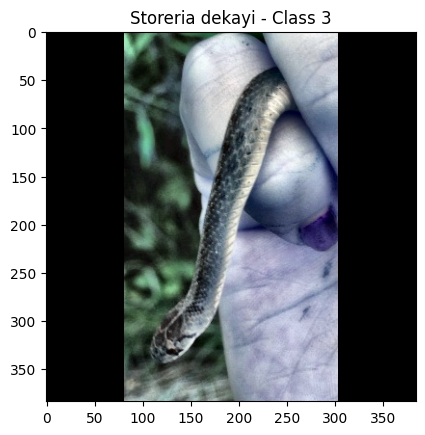

In [105]:
imagem = cv2.imread(new_image_path)
plt.imshow(imagem)
plt.title(predicted_class_name)